#### Source code credit [scikit-learn example](https://scikit-learn.org/stable/auto_examples/impute/plot_missing_values.html#sphx-glr-auto-examples-impute-plot-missing-values-py)

In [44]:
%matplotlib inline


# Imputing missing values before building an estimator

Missing values can be replaced by the mean, the median or the most frequent
value using the basic :class:`~sklearn.impute.SimpleImputer`.

In this example we will investigate different imputation techniques:

- imputation by the constant value 0
- imputation by the mean value of each feature combined with a missing-ness
  indicator auxiliary variable
- k nearest neighbor imputation
- iterative imputation

We will use two datasets: Diabetes dataset which consists of 10 feature
variables collected from diabetes patients with an aim to predict disease
progression and California Housing dataset for which the target is the median
house value for California districts.

As neither of these datasets have missing values, we will remove some
values to create new versions with artificially missing data. The performance
of
:class:`~sklearn.ensemble.RandomForestRegressor` on the full original dataset
is then compared the performance on the altered datasets with the artificially
missing values imputed using different techniques.


In [45]:
print(__doc__)

# Authors: Maria Telenczuk  <https://github.com/maikia>
# License: BSD 3 clause

Automatically created module for IPython interactive environment


## Download the data and make missing values sets

 First we download the two datasets. Diabetes dataset is shipped with
 scikit-learn. It has 442 entries, each with 10 features. California Housing
 dataset is much larger with 20640 entries and 8 features. It needs to be
 downloaded. We will only use the first 400 entries for the sake of speeding
 up the calculations but feel free to use the whole dataset.




Diabetes dataset is documented [here]()

>Samples total 442  
Dimensionality 10  
Features real, -.2 < x < .2  
Targets  
integer 25 - 346

In [46]:
import numpy as np

from sklearn.datasets import fetch_california_housing
from sklearn.datasets import load_diabetes


rng = np.random.RandomState(42)

X_diabetes, y_diabetes = load_diabetes(return_X_y=True, as_frame=True)  ##show df with column names
X_california, y_california = fetch_california_housing(return_X_y=True)
X_california = X_california[:400]
y_california = y_california[:400]

def add_missing_values(X_full, y_full):
    n_samples, n_features = X_full.shape

    # Add missing values in 75% of the lines
    missing_rate = 0.75
    n_missing_samples = int(n_samples * missing_rate)

    missing_samples = np.zeros(n_samples, dtype=bool)
    missing_samples[: n_missing_samples] = True

    rng.shuffle(missing_samples)
    missing_features = rng.randint(0, n_features, n_missing_samples)
    X_missing = X_full.copy()
    X_missing[missing_samples, missing_features] = np.nan
    y_missing = y_full.copy()

    return X_missing, y_missing


In [47]:
## shape of diabetes
X_diabetes, y_diabetes

(          age       sex       bmi        bp        s1        s2        s3  \
 0    0.038076  0.050680  0.061696  0.021872 -0.044223 -0.034821 -0.043401   
 1   -0.001882 -0.044642 -0.051474 -0.026328 -0.008449 -0.019163  0.074412   
 2    0.085299  0.050680  0.044451 -0.005671 -0.045599 -0.034194 -0.032356   
 3   -0.089063 -0.044642 -0.011595 -0.036656  0.012191  0.024991 -0.036038   
 4    0.005383 -0.044642 -0.036385  0.021872  0.003935  0.015596  0.008142   
 ..        ...       ...       ...       ...       ...       ...       ...   
 437  0.041708  0.050680  0.019662  0.059744 -0.005697 -0.002566 -0.028674   
 438 -0.005515  0.050680 -0.015906 -0.067642  0.049341  0.079165 -0.028674   
 439  0.041708  0.050680 -0.015906  0.017282 -0.037344 -0.013840 -0.024993   
 440 -0.045472 -0.044642  0.039062  0.001215  0.016318  0.015283 -0.028674   
 441 -0.045472 -0.044642 -0.073030 -0.081414  0.083740  0.027809  0.173816   
 
            s4        s5        s6  
 0   -0.002592  0.019908 

In [48]:
X_diabetes, y_diabetes = load_diabetes(return_X_y=True, as_frame=False) ## X and y are now numpy.ndarray objects

#### original datasets have no missing values -- so we first corrupt the dataset

In [49]:
X_miss_california, y_miss_california = add_missing_values(
    X_california, y_california)

X_miss_diabetes, y_miss_diabetes = add_missing_values(
    X_diabetes, y_diabetes)

## Impute the missing data and score
Now we will write a function which will score the results on the differently
imputed data. Let's look at each imputer separately:




In [50]:
rng = np.random.RandomState(0)

from sklearn.ensemble import RandomForestRegressor

# To use the experimental IterativeImputer, we need to explicitly ask for it:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline


N_SPLITS = 5
regressor = RandomForestRegressor(random_state=0)

### Missing information
In addition to imputing the missing values, the imputers have an
`add_indicator` parameter that marks the values that were missing, which
might carry some information.




In [51]:
def get_scores_for_imputer(imputer, X_missing, y_missing):
    estimator = make_pipeline(imputer, regressor)
    impute_scores = cross_val_score(estimator, X_missing, y_missing,
                                    scoring='neg_mean_squared_error',
                                    cv=N_SPLITS)
    return impute_scores


x_labels = ['Full data',
            'Zero imputation',
            'Mean Imputation',
            'KNN Imputation',
            'Iterative Imputation']

mses_california = np.zeros(5)
stds_california = np.zeros(5)
mses_diabetes = np.zeros(5)
stds_diabetes = np.zeros(5)

### Estimate the score
First, we want to estimate the score on the original data:




In [52]:
def get_full_score(X_full, y_full):
    full_scores = cross_val_score(regressor, X_full, y_full,
                                  scoring='neg_mean_squared_error',
                                  cv=N_SPLITS)
    return full_scores.mean(), full_scores.std()


mses_c, stds_c  = get_full_score(X_california,y_california)
mses_d, stds_d = get_full_score(X_diabetes, y_diabetes)

mses_california[0] = mses_c
stds_california[0] = stds_c
mses_diabetes[0] = mses_d
stds_diabetes[0] = stds_d


## report scores
print(mses_c, stds_c)
print(mses_d, stds_d)

-0.23844650227159853 0.16525828238107595
-3340.452878151175 237.6815916958605


### Replace missing values by 0

Now we will estimate the score on the data where the missing values are
replaced by 0:




In [53]:
def get_impute_zero_score(X_missing, y_missing):

    imputer = SimpleImputer(missing_values=np.nan, add_indicator=True,
                            strategy='constant', fill_value=0)
    zero_impute_scores = get_scores_for_imputer(imputer, X_missing, y_missing)
    return zero_impute_scores.mean(), zero_impute_scores.std()

mses_c, stds_c  = get_impute_zero_score(X_miss_california, y_miss_california)
mses_d, stds_d = get_impute_zero_score(X_miss_diabetes, y_miss_diabetes)

mses_california[1] = mses_c
stds_california[1] = stds_c
mses_diabetes[1] = mses_d
stds_diabetes[1] = stds_d

## report scores
print(mses_c, stds_c)
print(mses_d, stds_d)

-0.30815471240865444 0.21282349509757306
-3525.6014768973446 366.9245632939117


### Replace missing values by mean of column values

Now we will estimate the score on the data where the missing values are
replaced by the mean of the available values:

In [54]:
def get_impute_mean_score(X_missing, y_missing):

    imputer = SimpleImputer(missing_values=np.nan, add_indicator=True,
                            strategy='mean')
    zero_impute_scores = get_scores_for_imputer(imputer, X_missing, y_missing)
    return zero_impute_scores.mean(), zero_impute_scores.std()

mses_c, stds_c  = get_impute_mean_score(X_miss_california, y_miss_california)
mses_d, stds_d = get_impute_mean_score(X_miss_diabetes, y_miss_diabetes)

mses_california[2] = mses_c
stds_california[2] = stds_c
mses_diabetes[2] = mses_d
stds_diabetes[2] = stds_d

## report scores
print(mses_c, stds_c)
print(mses_d, stds_d)

-0.273388195430304 0.208576447846458
-3535.676958421859 355.9189290703317


### kNN-imputation of the missing values

:class:`~sklearn.impute.KNNImputer` imputes missing values using the weighted
or unweighted mean of the desired number of nearest neighbors.



In [55]:
def get_impute_knn_score(X_missing, y_missing):
    imputer = KNNImputer(missing_values=np.nan, add_indicator=True)
    knn_impute_scores = get_scores_for_imputer(imputer, X_missing, y_missing)
    return knn_impute_scores.mean(), knn_impute_scores.std()


mses_c, stds_c  = get_impute_knn_score(X_miss_california, y_miss_california)
mses_d, stds_d = get_impute_knn_score(X_miss_diabetes, y_miss_diabetes)

mses_california[3] = mses_c
stds_california[3] = stds_c
mses_diabetes[3] = mses_d
stds_diabetes[3] = stds_d

## report scores
print(mses_c, stds_c)
print(mses_d, stds_d)

-0.29743642881605964 0.21596911152728376
-3494.506668416752 296.58033442080665


### Iterative imputation of the missing values

Another option is the :class:`~sklearn.impute.IterativeImputer`. This uses
round-robin linear regression, modeling each feature with missing values as a
function of other features, in turn.
The version implemented assumes Gaussian (output) variables. If your features
are obviously non-normal, consider transforming them to look more normal
to potentially improve performance.




In [56]:
def get_impute_iterative(X_missing, y_missing):
    imputer = IterativeImputer(missing_values=np.nan, add_indicator=True,
                               random_state=0, n_nearest_features=5,
                               sample_posterior=True)
    iterative_impute_scores = get_scores_for_imputer(imputer,
                                                     X_missing,
                                                     y_missing)
    return iterative_impute_scores.mean(), iterative_impute_scores.std()

mses_c, stds_c  = get_impute_iterative(X_miss_california, y_miss_california)
mses_d, stds_d = get_impute_iterative(X_miss_diabetes, y_miss_diabetes)

mses_california[4] = mses_c
stds_california[4] = stds_c
mses_diabetes[4] = mses_d
stds_diabetes[4] = stds_d

## report scores
print(mses_c, stds_c)
print(mses_d, stds_d)

-0.311227478057019 0.22095042223020386
-3505.0721091011233 261.8069778495589


In [57]:
## make all scores positive

mses_diabetes = mses_diabetes * -1
mses_california = mses_california * -1

## Plot the results

Finally we are going to visualize the score:




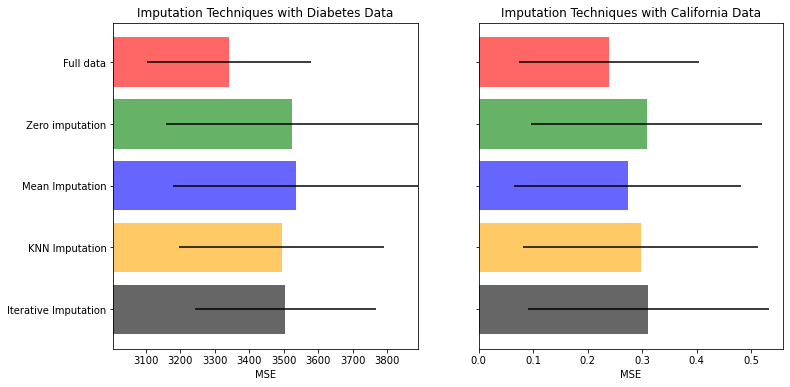

In [58]:
import matplotlib.pyplot as plt


n_bars = len(mses_diabetes)
xval = np.arange(n_bars)

colors = ['r', 'g', 'b', 'orange', 'black']

# plot diabetes results
plt.figure(figsize=(12, 6))
ax1 = plt.subplot(121)
for j in xval:
    ax1.barh(j, mses_diabetes[j], xerr=stds_diabetes[j],
             color=colors[j], alpha=0.6, align='center')

ax1.set_title('Imputation Techniques with Diabetes Data')
ax1.set_xlim(left=np.min(mses_diabetes) * 0.9,
             right=np.max(mses_diabetes) * 1.1)
ax1.set_yticks(xval)
ax1.set_xlabel('MSE')
ax1.invert_yaxis()
ax1.set_yticklabels(x_labels)

# plot california dataset results
ax2 = plt.subplot(122)
for j in xval:
    ax2.barh(j, mses_california[j], xerr=stds_california[j],
             color=colors[j], alpha=0.6, align='center')

ax2.set_title('Imputation Techniques with California Data')
ax2.set_yticks(xval)
ax2.set_xlabel('MSE')
ax2.invert_yaxis()
ax2.set_yticklabels([''] * n_bars)

plt.show()

# You can also try different techniques. For instance, the median is a more
# robust estimator for data with high magnitude variables which could dominate
# results (otherwise known as a 'long tail').